# GPQA-D Performance Regression Analysis

This notebook performs multiple regression analysis to understand how GPQA-D performance improves over time.

**Key Questions:**
1. How much does performance improve per year **without controlling for price**?
2. How much does performance improve per year **controlling for price**?
3. What is the effect of price on performance?

**Methodology:**
- Dependent variable: logit(GPQA-D) = log(p / (1-p))
- Independent variables: Time (years since start), log(Price)
- Two models:
  - Model 1: logit(GPQA-D) ~ time
  - Model 2: logit(GPQA-D) ~ time + log(price)
- Option to use Pareto frontier only or all models

In [151]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg

## Load and Prepare Data

In [152]:
# Define logit transformation functions
def logit(p):
    """Convert probability to logit scale"""
    p_clipped = np.clip(p, 0.001, 0.999)
    return np.log(p_clipped / (1 - p_clipped))

def inverse_logit(logit_val):
    """Convert logit back to probability"""
    return 1 / (1 + np.exp(-logit_val))

In [153]:
# Load the data
df = pd.read_csv('data/price_reduction_models.csv')

# Convert Release Date to datetime
df['Release Date'] = pd.to_datetime(df['Release Date'])

# Clean GPQA-D column (epoch_gpqa) - convert percentage strings to floats
df['GPQA_D'] = df['epoch_gpqa'].astype(str).str.replace('%', '').astype(float)

# Clean Benchmark Cost USD - convert string with $ and commas to float
df['Price'] = df['Benchmark Cost USD'].astype(str).str.replace('[$,]', '', regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Filter out rows with missing data
df_clean = df[['Model', 'Release Date', 'GPQA_D', 'Price']].dropna()
df_clean = df_clean[df_clean['Price'] > 0]

print(f"Total models with complete data: {len(df_clean)}")
print(f"Date range: {df_clean['Release Date'].min()} to {df_clean['Release Date'].max()}")
print(f"GPQA-D range: {df_clean['GPQA_D'].min():.1f}% to {df_clean['GPQA_D'].max():.1f}%")
print(f"Price range: ${df_clean['Price'].min():.2f} to ${df_clean['Price'].max():.2f}")

Total models with complete data: 138
Date range: 2024-04-01 00:00:00 to 2025-10-01 00:00:00
GPQA-D range: 13.2% to 86.2%
Price range: $0.00 to $76.30


In [154]:
# Add logit column (convert percentage to decimal first)
df_clean['GPQA_D_logit'] = logit(df_clean['GPQA_D'] / 100)

# Add log price (for regression)
df_clean['log_Price'] = np.log10(df_clean['Price'])

# Add ordinal date for regression (normalize to years for interpretability)
min_date_ordinal = df_clean['Release Date'].min().toordinal()
df_clean['Date_Ordinal'] = df_clean['Release Date'].map(datetime.toordinal)
df_clean['Years_Since_Start'] = (df_clean['Date_Ordinal'] - min_date_ordinal) / 365.25

print("\nTransformations complete:")
print(f"Logit(GPQA-D) range: {df_clean['GPQA_D_logit'].min():.2f} to {df_clean['GPQA_D_logit'].max():.2f}")
print(f"Log10(Price) range: {df_clean['log_Price'].min():.2f} to {df_clean['log_Price'].max():.2f}")
print(f"Years since start: 0 to {df_clean['Years_Since_Start'].max():.2f}")


Transformations complete:
Logit(GPQA-D) range: -1.88 to 1.83
Log10(Price) range: -2.35 to 1.88
Years since start: 0 to 1.50


## Regression Analysis Function

This function performs two regressions:
1. **Model 1**: logit(GPQA-D) ~ time (no price control)
2. **Model 2**: logit(GPQA-D) ~ time + log(price) (controlling for price)

We use sklearn LinearRegression with manual calculation of statistics (standard errors, p-values, confidence intervals).

In [155]:
def _run_two_regressions(df_analysis, analysis_type):
    """Run the with/without price-control regressions on a pre-filtered sample."""
    print(f"\n{'='*80}")
    print(f"Analyzing {len(df_analysis)} models ({analysis_type})")
    print(
        f"Date range: {df_analysis['Release Date'].min().strftime('%Y-%m-%d')} to {df_analysis['Release Date'].max().strftime('%Y-%m-%d')}"
    )
    print(f"GPQA-D range: {df_analysis['GPQA_D'].min():.1f}% to {df_analysis['GPQA_D'].max():.1f}%")
    print(f"{'='*80}\n")

    # Prepare data for regression
    y = df_analysis['GPQA_D_logit'].values
    X_time = df_analysis[['Years_Since_Start']].values
    X_time_price = df_analysis[['Years_Since_Start', 'log_Price']].values

    # Model 1: logit(GPQA-D) ~ time (no price control)
    model1 = LinearRegression().fit(X_time, y)
    y_pred1 = model1.predict(X_time)

    # Model 2: logit(GPQA-D) ~ time + log(price) (controlling for price)
    model2 = LinearRegression().fit(X_time_price, y)
    y_pred2 = model2.predict(X_time_price)

    # Calculate R-squared
    r_squared1 = model1.score(X_time, y)
    r_squared2 = model2.score(X_time_price, y)

    # Calculate statistics for Model 1
    n1 = len(y)
    residuals1 = y - y_pred1
    mse1 = np.sum(residuals1**2) / (n1 - 2)  # n - p - 1, where p=1

    # Standard error for time coefficient (Model 1)
    X_time_centered = X_time - np.mean(X_time)
    se_time1 = np.sqrt(mse1 / np.sum(X_time_centered**2))

    # t-statistic and p-value
    t_stat1 = model1.coef_[0] / se_time1
    p_value1 = 2 * (1 - stats.t.cdf(np.abs(t_stat1), n1 - 2))

    # 95% confidence interval
    t_crit1 = stats.t.ppf(0.975, n1 - 2)
    ci_lower1 = model1.coef_[0] - t_crit1 * se_time1
    ci_upper1 = model1.coef_[0] + t_crit1 * se_time1

    # Calculate statistics for Model 2
    n2 = len(y)
    residuals2 = y - y_pred2
    mse2 = np.sum(residuals2**2) / (n2 - 3)  # n - p - 1, where p=2

    # Standard errors for coefficients (Model 2)
    # Using the formula: SE = sqrt(MSE * (X'X)^-1)
    XtX_inv = np.linalg.inv(X_time_price.T @ X_time_price)
    se_coefs2 = np.sqrt(np.diag(XtX_inv) * mse2)

    se_time2 = se_coefs2[0]
    se_price2 = se_coefs2[1]

    # t-statistics and p-values
    t_stat_time2 = model2.coef_[0] / se_time2
    t_stat_price2 = model2.coef_[1] / se_price2

    p_value_time2 = 2 * (1 - stats.t.cdf(np.abs(t_stat_time2), n2 - 3))
    p_value_price2 = 2 * (1 - stats.t.cdf(np.abs(t_stat_price2), n2 - 3))

    # 95% confidence intervals
    t_crit2 = stats.t.ppf(0.975, n2 - 3)
    ci_lower_time2 = model2.coef_[0] - t_crit2 * se_time2
    ci_upper_time2 = model2.coef_[0] + t_crit2 * se_time2

    # Calculate approximate percentage point improvements
    mean_gpqa = df_analysis['GPQA_D'].mean()
    mean_logit_val = logit(mean_gpqa / 100)

    # Model 1: annual improvement
    future_logit_1 = mean_logit_val + model1.coef_[0]
    future_prob_1 = inverse_logit(future_logit_1) * 100
    annual_pct_1 = future_prob_1 - mean_gpqa

    # Model 2: annual improvement
    future_logit_2 = mean_logit_val + model2.coef_[0]
    future_prob_2 = inverse_logit(future_logit_2) * 100
    annual_pct_2 = future_prob_2 - mean_gpqa

    # Create summary results
    results = []

    # Model 1 results
    results.append({
        'Model': 'Without Price Control',
        'Specification': 'logit(GPQA-D) ~ time',
        'Time_Coefficient': model1.coef_[0],
        'Time_Std_Err': se_time1,
        'Time_p_value': p_value1,
        'Time_CI_Lower': ci_lower1,
        'Time_CI_Upper': ci_upper1,
        'Annual_Improvement_Logits': model1.coef_[0],
        'Annual_Improvement_PctPts': annual_pct_1,
        'Price_Coefficient': np.nan,
        'Price_Std_Err': np.nan,
        'Price_p_value': np.nan,
        'R_Squared': r_squared1,
        'Adj_R_Squared': 1 - (1 - r_squared1) * (n1 - 1) / (n1 - 2),
        'N_Models': len(df_analysis),
        'Mean_GPQA_D': mean_gpqa
    })

    # Model 2 results
    results.append({
        'Model': 'With Price Control',
        'Specification': 'logit(GPQA-D) ~ time + log(price)',
        'Time_Coefficient': model2.coef_[0],
        'Time_Std_Err': se_time2,
        'Time_p_value': p_value_time2,
        'Time_CI_Lower': ci_lower_time2,
        'Time_CI_Upper': ci_upper_time2,
        'Annual_Improvement_Logits': model2.coef_[0],
        'Annual_Improvement_PctPts': annual_pct_2,
        'Price_Coefficient': model2.coef_[1],
        'Price_Std_Err': se_price2,
        'Price_p_value': p_value_price2,
        'R_Squared': r_squared2,
        'Adj_R_Squared': 1 - (1 - r_squared2) * (n2 - 1) / (n2 - 3),
        'N_Models': len(df_analysis),
        'Mean_GPQA_D': mean_gpqa
    })

    results_df = pd.DataFrame(results)

    return {
        'results_df': results_df,
        'model1': model1,
        'model2': model2,
        'data': df_analysis,
        'analysis_type': analysis_type
    }


def perform_regression_analysis(df, use_pareto_only=True, min_date=None):
    """Perform regression on either the Pareto frontier sample or all models."""

    df_work = df.copy()

    # Apply date filter if specified
    if min_date is not None:
        if isinstance(min_date, str):
            min_date = pd.to_datetime(min_date)
        df_work = df_work[df_work['Release Date'] >= min_date]

    # Sort by date
    df_work = df_work.sort_values('Release Date')

    # Get Pareto frontier if requested
    if use_pareto_only:
        # Identify Pareto frontier models at each point in time
        # A model is on the Pareto frontier if no other model dominates it
        # (i.e., no model with both better/equal performance and lower/equal price)
        pareto_indices = []

        for date in df_work['Release Date'].unique():
            # Get all models available at this date
            available_models = df_work[df_work['Release Date'] <= date].copy()

            # Find Pareto frontier at this date
            available_models = available_models.sort_values(['Price', 'GPQA_D'])
            frontier_indices = []

            for i, row in available_models.iterrows():
                # Check if this model is on the Pareto frontier
                dominated = False
                for j in frontier_indices:
                    frontier_row = available_models.loc[j]
                    # A model is dominated if there exists another model with:
                    # 1. Better or equal GPQA-D score AND
                    # 2. Lower or equal price
                    # AND at least one is strictly better
                    if (
                        frontier_row['GPQA_D'] >= row['GPQA_D']
                        and frontier_row['Price'] <= row['Price']
                        and (
                            frontier_row['GPQA_D'] > row['GPQA_D']
                            or frontier_row['Price'] < row['Price']
                        )
                    ):
                        dominated = True
                        break

                if not dominated:
                    frontier_indices.append(i)
                    # Remove any previously added models that this one dominates
                    new_frontier_indices = []
                    for j in frontier_indices[:-1]:
                        frontier_row = available_models.loc[j]
                        if not (
                            row['GPQA_D'] >= frontier_row['GPQA_D']
                            and row['Price'] <= frontier_row['Price']
                            and (
                                row['GPQA_D'] > frontier_row['GPQA_D']
                                or row['Price'] < frontier_row['Price']
                            )
                        ):
                            new_frontier_indices.append(j)
                    frontier_indices = new_frontier_indices + [i]

            # Add models released exactly on this date that are on the frontier
            current_date_models = df_work[df_work['Release Date'] == date]
            for i, row in current_date_models.iterrows():
                if i in frontier_indices:
                    pareto_indices.append(i)

        # Remove duplicates and use for regression
        pareto_indices = list(set(pareto_indices))
        df_analysis = df_work.loc[pareto_indices].copy()
        analysis_type = "Pareto Frontier"
    else:
        df_analysis = df_work.copy()
        analysis_type = "All Models"

    return _run_two_regressions(df_analysis, analysis_type)


def perform_frontier_regression_analysis(df, min_date=None):
    """Perform regression on performance frontier models.

    Performance frontier = models that achieve strictly better GPQA-D than any previously released model.
    Only one model per date can be on the frontier (the best model on that date, if it beats all previous).
    """
    df_work = df.copy()

    # Apply date filter if specified
    if min_date is not None:
        if isinstance(min_date, str):
            min_date = pd.to_datetime(min_date)
        df_work = df_work[df_work['Release Date'] >= min_date]

    # Sort by date ascending, GPQA_D descending so best model on each date is first
    # This ensures at most one frontier model per date
    df_work = df_work.sort_values(['Release Date', 'GPQA_D'], ascending=[True, False])

    prev_best = df_work['GPQA_D'].cummax().shift(1)
    df_work['Is_Performance_Frontier'] = df_work['GPQA_D'] > prev_best.fillna(-np.inf)

    df_analysis = df_work[df_work['Is_Performance_Frontier']].copy()
    analysis_type = "Performance Frontier (new best GPQA-D over time)"

    return _run_two_regressions(df_analysis, analysis_type)

## Analysis 1: Pareto Frontier

Using only the best-performing models over time (Pareto frontier).

In [156]:
# Run analysis on Pareto frontier
print("\n" + "="*100)
print("ANALYSIS 1: PARETO FRONTIER")
print("="*100)
results_pareto = perform_regression_analysis(
    df_clean,
    use_pareto_only=True,
    min_date=datetime(2024, 4, 1)
)


ANALYSIS 1: PARETO FRONTIER

Analyzing 53 models (Pareto Frontier)
Date range: 2024-04-01 to 2025-09-01
GPQA-D range: 25.2% to 86.2%



## Analysis 2: All Models

Using all models in the dataset.

In [157]:
# Run analysis on all models
print("\n" + "="*100)
print("ANALYSIS 2: ALL MODELS")
print("="*100)
results_all = perform_regression_analysis(
    df_clean,
    use_pareto_only=False,
    min_date=datetime(2024, 4, 1)
)

# Run analysis on performance frontier (new best GPQA-D over time)
print("\n" + "="*100)
print("ANALYSIS 3: PERFORMANCE FRONTIER (NEW BEST GPQA-D OVER TIME)")
print("="*100)
results_frontier = perform_frontier_regression_analysis(
    df_clean,
    min_date=datetime(2024, 4, 1)
)


ANALYSIS 2: ALL MODELS

Analyzing 138 models (All Models)
Date range: 2024-04-01 to 2025-10-01
GPQA-D range: 13.2% to 86.2%


ANALYSIS 3: PERFORMANCE FRONTIER (NEW BEST GPQA-D OVER TIME)

Analyzing 7 models (Performance Frontier (new best GPQA-D over time))
Date range: 2024-04-01 to 2025-08-01
GPQA-D range: 59.5% to 86.2%



## Load and Prepare SWE-Bench and AIME Data

Now let's load and prepare data for SWE-Bench and AIME to compare across benchmarks.

In [158]:
# Load SWE-Bench data - use dedicated file with benchmark-specific costs
df_swe = pd.read_csv('data/swe_price_reduction_models.csv')

# Convert Release Date to datetime
df_swe['Release Date'] = pd.to_datetime(df_swe['Release Date'])

# Clean SWE-Bench column (epoch_swe) - convert percentage strings to floats
df_swe['SWE_Bench'] = df_swe['epoch_swe'].astype(str).str.replace('%', '').astype(float)

# Clean Benchmark Cost USD - convert string with $ and commas to float
df_swe['Price'] = df_swe['Benchmark Cost USD'].astype(str).str.replace('[$,]', '', regex=True)
df_swe['Price'] = pd.to_numeric(df_swe['Price'], errors='coerce')

# Filter out rows with missing data
df_swe_clean = df_swe[['Model', 'Release Date', 'SWE_Bench', 'Price']].dropna()
df_swe_clean = df_swe_clean[df_swe_clean['Price'] > 0]
df_swe_clean = df_swe_clean[df_swe_clean['SWE_Bench'] > 0]

# Add logit column (convert percentage to decimal first)
df_swe_clean['SWE_Bench_logit'] = logit(df_swe_clean['SWE_Bench'] / 100)

# Add log price (for regression)
df_swe_clean['log_Price'] = np.log10(df_swe_clean['Price'])

# Add ordinal date for regression (normalize to years for interpretability)
min_date_ordinal_swe = df_swe_clean['Release Date'].min().toordinal()
df_swe_clean['Date_Ordinal'] = df_swe_clean['Release Date'].map(datetime.toordinal)
df_swe_clean['Years_Since_Start'] = (df_swe_clean['Date_Ordinal'] - min_date_ordinal_swe) / 365.25

print(f"SWE-Bench: Total models with complete data: {len(df_swe_clean)}")
print(f"Date range: {df_swe_clean['Release Date'].min()} to {df_swe_clean['Release Date'].max()}")
print(f"SWE-Bench range: {df_swe_clean['SWE_Bench'].min():.1f}% to {df_swe_clean['SWE_Bench'].max():.1f}%")
print(f"Price range: ${df_swe_clean['Price'].min():.2f} to ${df_swe_clean['Price'].max():.2f}")

SWE-Bench: Total models with complete data: 21
Date range: 2024-10-01 00:00:00 to 2025-10-01 00:00:00
SWE-Bench range: 16.4% to 64.8%
Price range: $24.06 to $1416.49


In [159]:
# Multi-benchmark regression function - must be defined before use
def perform_benchmark_regression(df, name, score_col, logit_col, use_pareto_only=True, min_date=None):
    """Perform regression for any benchmark (not just GPQA-D)."""
    df_work = df.copy()
    if min_date: 
        df_work = df_work[df_work['Release Date'] >= pd.to_datetime(min_date)]
    df_work = df_work.sort_values('Release Date')
    
    if use_pareto_only:
        pareto_indices = []
        for date in df_work['Release Date'].unique():
            avail = df_work[df_work['Release Date'] <= date].copy().sort_values(['Price', score_col])
            frontier = []
            for i, row in avail.iterrows():
                dominated = any(avail.loc[j, score_col] >= row[score_col] and avail.loc[j, 'Price'] <= row['Price'] 
                               and (avail.loc[j, score_col] > row[score_col] or avail.loc[j, 'Price'] < row['Price']) for j in frontier)
                if not dominated:
                    frontier = [j for j in frontier if not (row[score_col] >= avail.loc[j, score_col] and row['Price'] <= avail.loc[j, 'Price']
                                                             and (row[score_col] > avail.loc[j, score_col] or row['Price'] < avail.loc[j, 'Price']))] + [i]
            pareto_indices.extend([i for i, _ in df_work[df_work['Release Date'] == date].iterrows() if i in frontier])
        df_analysis = df_work.loc[list(set(pareto_indices))].copy()
        analysis_type = f"{name} Pareto Frontier"
    else:
        df_analysis = df_work.copy()
        analysis_type = f"{name} All Models"
    
    if len(df_analysis) < 3:
        print(f"Warning: Not enough data for {analysis_type} (n={len(df_analysis)})")
        return None
    
    y = df_analysis[logit_col].values
    X_t = df_analysis[['Years_Since_Start']].values
    X_tp = df_analysis[['Years_Since_Start', 'log_Price']].values
    m1 = LinearRegression().fit(X_t, y)
    m2 = LinearRegression().fit(X_tp, y)
    n = len(y)
    se1 = np.sqrt(np.sum((y - m1.predict(X_t))**2) / (n-2) / np.sum((X_t - X_t.mean())**2))
    XtX_inv = np.linalg.inv(X_tp.T @ X_tp)
    se2 = np.sqrt(np.diag(XtX_inv) * np.sum((y - m2.predict(X_tp))**2) / (n-3))
    t1, t2 = m1.coef_[0]/se1, m2.coef_[0]/se2[0]
    p1, p2 = 2*(1-stats.t.cdf(abs(t1), n-2)), 2*(1-stats.t.cdf(abs(t2), n-3))
    mean_score = df_analysis[score_col].mean()
    ann1 = inverse_logit(logit(mean_score/100) + m1.coef_[0])*100 - mean_score
    ann2 = inverse_logit(logit(mean_score/100) + m2.coef_[0])*100 - mean_score
    
    print(f"\n{analysis_type}: {n} models")
    
    return {'results_df': pd.DataFrame([
        {'Benchmark': name, 'Model': 'Without Price Control', 'Time_Coefficient': m1.coef_[0], 'Time_Std_Err': se1,
         'Time_p_value': p1, 'Annual_Improvement_PctPts': ann1, 'Price_Coefficient': np.nan, 'N_Models': n,
         'R_Squared': m1.score(X_t, y), 'Adj_R_Squared': 1-(1-m1.score(X_t, y))*(n-1)/(n-2)},
        {'Benchmark': name, 'Model': 'With Price Control', 'Time_Coefficient': m2.coef_[0], 'Time_Std_Err': se2[0],
         'Time_p_value': p2, 'Annual_Improvement_PctPts': ann2, 'Price_Coefficient': m2.coef_[1], 'N_Models': n,
         'R_Squared': m2.score(X_tp, y), 'Adj_R_Squared': 1-(1-m2.score(X_tp, y))*(n-1)/(n-3)}
    ]), 'model1': m1, 'model2': m2, 'data': df_analysis}


def perform_frontier_benchmark_regression(df, name, score_col, logit_col, min_date=None):
    """Perform regression on performance frontier models for any benchmark.
    
    Performance frontier = models that achieve strictly better score than any previously released model.
    Only one model per date can be on the frontier (the best model on that date, if it beats all previous).
    """
    df_work = df.copy()
    if min_date:
        df_work = df_work[df_work['Release Date'] >= pd.to_datetime(min_date)]
    
    # Sort by date ascending, score descending so best model on each date is first
    # This ensures at most one frontier model per date
    df_work = df_work.sort_values(['Release Date', score_col], ascending=[True, False])
    
    prev_best = df_work[score_col].cummax().shift(1)
    df_work['Is_Performance_Frontier'] = df_work[score_col] > prev_best.fillna(-np.inf)
    
    df_analysis = df_work[df_work['Is_Performance_Frontier']].copy()
    analysis_type = f"{name} Performance Frontier"
    
    if len(df_analysis) < 3:
        print(f"Warning: Not enough data for {analysis_type} (n={len(df_analysis)})")
        return None
    
    y = df_analysis[logit_col].values
    X_t = df_analysis[['Years_Since_Start']].values
    X_tp = df_analysis[['Years_Since_Start', 'log_Price']].values
    m1 = LinearRegression().fit(X_t, y)
    m2 = LinearRegression().fit(X_tp, y)
    n = len(y)
    se1 = np.sqrt(np.sum((y - m1.predict(X_t))**2) / (n-2) / np.sum((X_t - X_t.mean())**2))
    XtX_inv = np.linalg.inv(X_tp.T @ X_tp)
    se2 = np.sqrt(np.diag(XtX_inv) * np.sum((y - m2.predict(X_tp))**2) / (n-3))
    t1, t2 = m1.coef_[0]/se1, m2.coef_[0]/se2[0]
    p1, p2 = 2*(1-stats.t.cdf(abs(t1), n-2)), 2*(1-stats.t.cdf(abs(t2), n-3))
    mean_score = df_analysis[score_col].mean()
    ann1 = inverse_logit(logit(mean_score/100) + m1.coef_[0])*100 - mean_score
    ann2 = inverse_logit(logit(mean_score/100) + m2.coef_[0])*100 - mean_score
    
    print(f"\n{analysis_type}: {n} models")
    
    return {'results_df': pd.DataFrame([
        {'Benchmark': name, 'Model': 'Without Price Control', 'Time_Coefficient': m1.coef_[0], 'Time_Std_Err': se1,
         'Time_p_value': p1, 'Annual_Improvement_PctPts': ann1, 'Price_Coefficient': np.nan, 'N_Models': n,
         'R_Squared': m1.score(X_t, y), 'Adj_R_Squared': 1-(1-m1.score(X_t, y))*(n-1)/(n-2)},
        {'Benchmark': name, 'Model': 'With Price Control', 'Time_Coefficient': m2.coef_[0], 'Time_Std_Err': se2[0],
         'Time_p_value': p2, 'Annual_Improvement_PctPts': ann2, 'Price_Coefficient': m2.coef_[1], 'N_Models': n,
         'R_Squared': m2.score(X_tp, y), 'Adj_R_Squared': 1-(1-m2.score(X_tp, y))*(n-1)/(n-3)}
    ]), 'model1': m1, 'model2': m2, 'data': df_analysis}

## Multi-Benchmark Summary Table

In [160]:
# Load AIME data  
df_aime = pd.read_csv('data/aime_price_reduction_models.csv')
df_aime['Release Date'] = pd.to_datetime(df_aime['Release Date'])
df_aime['AIME'] = df_aime['oneshot_AIME'].astype(str).str.replace('%', '').astype(float)
df_aime['Price'] = df_aime['Benchmark Cost USD'].astype(str).str.replace('[$,]', '', regex=True)
df_aime['Price'] = pd.to_numeric(df_aime['Price'], errors='coerce')
df_aime_clean = df_aime[['Model', 'Release Date', 'AIME', 'Price']].dropna()
df_aime_clean = df_aime_clean[(df_aime_clean['Price'] > 0) & (df_aime_clean['AIME'] > 0)]
df_aime_clean['AIME_logit'] = logit(df_aime_clean['AIME'] / 100)
df_aime_clean['log_Price'] = np.log10(df_aime_clean['Price'])
min_date_ordinal_aime = df_aime_clean['Release Date'].min().toordinal()
df_aime_clean['Date_Ordinal'] = df_aime_clean['Release Date'].map(datetime.toordinal)
df_aime_clean['Years_Since_Start'] = (df_aime_clean['Date_Ordinal'] - min_date_ordinal_aime) / 365.25
print(f"\nAIME: {len(df_aime_clean)} models, {df_aime_clean['AIME'].min():.1f}%-{df_aime_clean['AIME'].max():.1f}%")


AIME: 109 models, 0.6%-91.4%


In [161]:
# Run SWE-Bench regressions (Pareto, Frontier, All)
print("\n" + "="*80)
print("SWE-BENCH REGRESSIONS")
print("="*80)
results_swe_pareto = perform_benchmark_regression(df_swe_clean, 'SWE-Bench', 'SWE_Bench', 'SWE_Bench_logit', True, datetime(2024, 4, 1))
results_swe_frontier = perform_frontier_benchmark_regression(df_swe_clean, 'SWE-Bench', 'SWE_Bench', 'SWE_Bench_logit', datetime(2024, 4, 1))
results_swe_all = perform_benchmark_regression(df_swe_clean, 'SWE-Bench', 'SWE_Bench', 'SWE_Bench_logit', False, datetime(2024, 4, 1))

# Run AIME regressions (Pareto, Frontier, All)
print("\n" + "="*80)
print("AIME REGRESSIONS")
print("="*80)
results_aime_pareto = perform_benchmark_regression(df_aime_clean, 'AIME', 'AIME', 'AIME_logit', True, datetime(2024, 4, 1))
results_aime_frontier = perform_frontier_benchmark_regression(df_aime_clean, 'AIME', 'AIME', 'AIME_logit', datetime(2024, 4, 1))
results_aime_all = perform_benchmark_regression(df_aime_clean, 'AIME', 'AIME', 'AIME_logit', False, datetime(2024, 4, 1))


SWE-BENCH REGRESSIONS

SWE-Bench Pareto Frontier: 13 models

SWE-Bench Performance Frontier: 5 models

SWE-Bench All Models: 21 models

AIME REGRESSIONS

AIME Pareto Frontier: 42 models

AIME Performance Frontier: 5 models

AIME All Models: 109 models


In [162]:
# Create multi-benchmark summary table
rows = []

# Helper to add results for a benchmark
def add_benchmark_rows(results_list, benchmark_name, sample_names):
    for r, sample_name in zip(results_list, sample_names):
        if r is None:
            continue
        for _, row in r['results_df'].iterrows():
            rows.append({
                'Benchmark': benchmark_name, 
                'Sample': sample_name, 
                'Model': row['Model'], 
                'N': int(row['N_Models']), 
                'Time Coef': row['Time_Coefficient'],
                'Time SE': row['Time_Std_Err'], 
                'Time p': row['Time_p_value'], 
                'Annual Δ (% pts)': row['Annual_Improvement_PctPts'], 
                'Price Coef': row['Price_Coefficient'],
                'R²': row['R_Squared'], 
                'Adj R²': row['Adj_R_Squared']
            })

# GPQA-D results (Pareto, Frontier, All)
add_benchmark_rows([results_pareto, results_frontier, results_all], 'GPQA-D', ['Pareto', 'Frontier', 'All'])

# SWE-Bench results (Pareto, Frontier, All)
add_benchmark_rows([results_swe_pareto, results_swe_frontier, results_swe_all], 'SWE-Bench', ['Pareto', 'Frontier', 'All'])

# AIME results (Pareto, Frontier, All)
add_benchmark_rows([results_aime_pareto, results_aime_frontier, results_aime_all], 'AIME', ['Pareto', 'Frontier', 'All'])

summary = pd.DataFrame(rows)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.precision', 4)
print("\n" + "="*120)
print("MULTI-BENCHMARK REGRESSION SUMMARY")
print("="*120)
print(summary.to_string(index=False))
summary.to_csv('results/multi_benchmark_summary.csv', index=False)
print("\n\nSaved to: results/multi_benchmark_summary.csv")


MULTI-BENCHMARK REGRESSION SUMMARY
Benchmark   Sample                 Model   N  Time Coef  Time SE     Time p  Annual Δ (% pts)  Price Coef     R²  Adj R²
   GPQA-D   Pareto Without Price Control  53     1.2955   0.2161 2.0830e-07           27.3904         NaN 0.4134  0.4019
   GPQA-D   Pareto    With Price Control  53     0.6783   0.0551 2.2204e-16           15.9361      0.5710 0.8806  0.8758
   GPQA-D Frontier Without Price Control   7     1.0068   0.0757 4.2983e-05           13.6759         NaN 0.9725  0.9670
   GPQA-D Frontier    With Price Control   7     1.0327   0.1042 5.8258e-04           13.9147     -0.0207 0.9731  0.9597
   GPQA-D      All Without Price Control 138     0.9640   0.1294 9.6665e-12           21.9442         NaN 0.2899  0.2847
   GPQA-D      All    With Price Control 138     0.5933   0.0393 0.0000e+00           14.2169      0.4998 0.7366  0.7326
SWE-Bench   Pareto Without Price Control  13     1.0804   0.5734 8.6208e-02           24.7929         NaN 0.2440  0.1

In [163]:
# Create comprehensive summary table
print("\n\n" + "="*120)
print("COMPREHENSIVE SUMMARY TABLE")
print("="*120 + "\n")

summary_rows = []

# Add Pareto frontier results
for _, row in results_pareto['results_df'].iterrows():
    summary_rows.append({
        'Sample': 'Pareto Frontier',
        'Model': row['Model'],
        'N': int(row['N_Models']),
        'Time Coef (logits/yr)': row['Time_Coefficient'],
        'Time Std Err': row['Time_Std_Err'],
        'Time p-value': row['Time_p_value'],
        '95% CI Lower': row['Time_CI_Lower'],
        '95% CI Upper': row['Time_CI_Upper'],
        'Annual Δ (% pts)': row['Annual_Improvement_PctPts'],
        'Price Coef': row['Price_Coefficient'],
        'Price p-value': row['Price_p_value'],
        'R²': row['R_Squared'],
        'Adj R²': row['Adj_R_Squared']
    })

# Add performance frontier results
for _, row in results_frontier['results_df'].iterrows():
    summary_rows.append({
        'Sample': 'Performance Frontier',
        'Model': row['Model'],
        'N': int(row['N_Models']),
        'Time Coef (logits/yr)': row['Time_Coefficient'],
        'Time Std Err': row['Time_Std_Err'],
        'Time p-value': row['Time_p_value'],
        '95% CI Lower': row['Time_CI_Lower'],
        '95% CI Upper': row['Time_CI_Upper'],
        'Annual Δ (% pts)': row['Annual_Improvement_PctPts'],
        'Price Coef': row['Price_Coefficient'],
        'Price p-value': row['Price_p_value'],
        'R²': row['R_Squared'],
        'Adj R²': row['Adj_R_Squared']
    })

# Add all models results
for _, row in results_all['results_df'].iterrows():
    summary_rows.append({
        'Sample': 'All Models',
        'Model': row['Model'],
        'N': int(row['N_Models']),
        'Time Coef (logits/yr)': row['Time_Coefficient'],
        'Time Std Err': row['Time_Std_Err'],
        'Time p-value': row['Time_p_value'],
        '95% CI Lower': row['Time_CI_Lower'],
        '95% CI Upper': row['Time_CI_Upper'],
        'Annual Δ (% pts)': row['Annual_Improvement_PctPts'],
        'Price Coef': row['Price_Coefficient'],
        'Price p-value': row['Price_p_value'],
        'R²': row['R_Squared'],
        'Adj R²': row['Adj_R_Squared']
    })

summary_table = pd.DataFrame(summary_rows)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.precision', 4)

print(summary_table.to_string(index=False))

# Save to CSV
summary_table.to_csv('results/gpqa_regression_summary.csv', index=False)
print("\n\nSummary table saved to: results/gpqa_regression_summary.csv")



COMPREHENSIVE SUMMARY TABLE

              Sample                 Model   N  Time Coef (logits/yr)  Time Std Err  Time p-value  95% CI Lower  95% CI Upper  Annual Δ (% pts)  Price Coef  Price p-value     R²  Adj R²
     Pareto Frontier Without Price Control  53                 1.2955        0.2161    2.0830e-07        0.8617        1.7293           27.3904         NaN            NaN 0.4134  0.4019
     Pareto Frontier    With Price Control  53                 0.6783        0.0551    2.2204e-16        0.5676        0.7891           15.9361      0.5710         0.0000 0.8806  0.8758
Performance Frontier Without Price Control   7                 1.0068        0.0757    4.2983e-05        0.8122        1.2014           13.6759         NaN            NaN 0.9725  0.9670
Performance Frontier    With Price Control   7                 1.0327        0.1042    5.8258e-04        0.7433        1.3221           13.9147     -0.0207         0.7726 0.9731  0.9597
          All Models Without Price Cont

## Key Insights

In [164]:
# Print key insights
print("\n\n" + "="*100)
print("KEY INSIGHTS")
print("="*100)

pareto_no_control = results_pareto['results_df'][results_pareto['results_df']['Model'] == 'Without Price Control'].iloc[0]
pareto_with_control = results_pareto['results_df'][results_pareto['results_df']['Model'] == 'With Price Control'].iloc[0]

frontier_no_control = results_frontier['results_df'][results_frontier['results_df']['Model'] == 'Without Price Control'].iloc[0]
frontier_with_control = results_frontier['results_df'][results_frontier['results_df']['Model'] == 'With Price Control'].iloc[0]

print("\n1. PARETO FRONTIER (Best Models Over Time):")
print(f"   N = {int(pareto_no_control['N_Models'])} models\n")

print("   Without controlling for price:")
print(f"   - Annual improvement: {pareto_no_control['Annual_Improvement_Logits']:.3f} logits/yr")
print(f"   - Approximate: {pareto_no_control['Annual_Improvement_PctPts']:.2f} percentage points/yr")
print(f"   - R² = {pareto_no_control['R_Squared']:.3f}")
print(f"   - p-value: {pareto_no_control['Time_p_value']:.4f}\n")

print("   Controlling for price:")
print(f"   - Annual improvement: {pareto_with_control['Annual_Improvement_Logits']:.3f} logits/yr")
print(f"   - Approximate: {pareto_with_control['Annual_Improvement_PctPts']:.2f} percentage points/yr")
print(f"   - Price effect: {pareto_with_control['Price_Coefficient']:.3f} logits per 10x price increase")
print(f"   - R² = {pareto_with_control['R_Squared']:.3f}")
print(f"   - Time p-value: {pareto_with_control['Time_p_value']:.4f}")
print(f"   - Price p-value: {pareto_with_control['Price_p_value']:.4f}\n")

coef_change_pareto = pareto_with_control['Annual_Improvement_Logits'] - pareto_no_control['Annual_Improvement_Logits']
pct_change_pareto = (coef_change_pareto / pareto_no_control['Annual_Improvement_Logits']) * 100

print("   Effect of controlling for price:")
print(f"   - Coefficient change: {coef_change_pareto:.3f} logits/yr ({pct_change_pareto:+.1f}%)")
if coef_change_pareto < 0:
    print("   - Interpretation: Some of the apparent progress is due to higher prices")
else:
    print("   - Interpretation: Progress is independent of (or enhanced beyond) price effects")

print("\n2. PERFORMANCE FRONTIER (New Best GPQA-D Over Time):")
print(f"   N = {int(frontier_no_control['N_Models'])} models\n")

print("   Without controlling for price:")
print(f"   - Annual improvement: {frontier_no_control['Annual_Improvement_Logits']:.3f} logits/yr")
print(f"   - Approximate: {frontier_no_control['Annual_Improvement_PctPts']:.2f} percentage points/yr")
print(f"   - R² = {frontier_no_control['R_Squared']:.3f}")
print(f"   - p-value: {frontier_no_control['Time_p_value']:.4f}\n")

print("   Controlling for price:")
print(f"   - Annual improvement: {frontier_with_control['Annual_Improvement_Logits']:.3f} logits/yr")
print(f"   - Approximate: {frontier_with_control['Annual_Improvement_PctPts']:.2f} percentage points/yr")
print(f"   - Price effect: {frontier_with_control['Price_Coefficient']:.3f} logits per 10x price increase")
print(f"   - R² = {frontier_with_control['R_Squared']:.3f}")
print(f"   - Time p-value: {frontier_with_control['Time_p_value']:.4f}")
print(f"   - Price p-value: {frontier_with_control['Price_p_value']:.4f}\n")

coef_change_frontier = frontier_with_control['Annual_Improvement_Logits'] - frontier_no_control['Annual_Improvement_Logits']
pct_change_frontier = (coef_change_frontier / frontier_no_control['Annual_Improvement_Logits']) * 100

print("   Effect of controlling for price:")
print(f"   - Coefficient change: {coef_change_frontier:.3f} logits/yr ({pct_change_frontier:+.1f}%)")
if coef_change_frontier < 0:
    print("   - Interpretation: Some of the apparent progress is due to higher prices")
else:
    print("   - Interpretation: Progress is independent of (or enhanced beyond) price effects")

print("\n" + "="*100)



KEY INSIGHTS

1. PARETO FRONTIER (Best Models Over Time):
   N = 53 models

   Without controlling for price:
   - Annual improvement: 1.295 logits/yr
   - Approximate: 27.39 percentage points/yr
   - R² = 0.413
   - p-value: 0.0000

   Controlling for price:
   - Annual improvement: 0.678 logits/yr
   - Approximate: 15.94 percentage points/yr
   - Price effect: 0.571 logits per 10x price increase
   - R² = 0.881
   - Time p-value: 0.0000
   - Price p-value: 0.0000

   Effect of controlling for price:
   - Coefficient change: -0.617 logits/yr (-47.6%)
   - Interpretation: Some of the apparent progress is due to higher prices

2. PERFORMANCE FRONTIER (New Best GPQA-D Over Time):
   N = 7 models

   Without controlling for price:
   - Annual improvement: 1.007 logits/yr
   - Approximate: 13.68 percentage points/yr
   - R² = 0.973
   - p-value: 0.0000

   Controlling for price:
   - Annual improvement: 1.033 logits/yr
   - Approximate: 13.91 percentage points/yr
   - Price effect: -0.02

## Interpretation Guide

**Time Coefficient (logits/yr)**: The annual rate of improvement in logit(GPQA-D). Higher = faster improvement.

**Annual Δ (% pts)**: Approximate annual improvement in percentage points, calculated at the mean performance level. More interpretable than logit units.

**Price Coefficient**: Effect of 10x increase in price on logit(GPQA-D). Positive = higher price models perform better.

**Without vs. With Price Control**:
- **Without**: Shows total performance improvement over time (includes effect of higher prices)
- **With**: Shows performance improvement holding price constant (pure algorithmic/data progress)
- **Difference**: Reveals how much of the progress is due to price vs. other factors

**R²**: Proportion of variance explained. Higher = better fit.

**p-values**: Statistical significance. p < 0.05 typically considered significant.

### Interpreting Partial Regression Plots

**What do these plots show?**

Partial regression plots (added-variable plots) visualize the **unique contribution** of each predictor variable after removing the effects of other predictors.

**Left plot - Time Effect (controlling for Price):**
- X-axis: Time residuals (variation in time not explained by price)
- Y-axis: Performance residuals (variation in performance not explained by price)
- The slope equals the **time coefficient** from the full model
- Shows: How much performance improves over time, holding price constant

**Right plot - Price Effect (controlling for Time):**
- X-axis: Price residuals (variation in price not explained by time)
- Y-axis: Performance residuals (variation in performance not explained by time)
- The slope equals the **price coefficient** from the full model
- Shows: How much performance improves with price, holding time constant

**Key Insights:**
- Strong linear patterns indicate the variable is important after controlling for others
- Scatter indicates the relationship after removing confounding effects
- The R² in each plot shows how much variance that predictor explains uniquely

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_partial_regression(df_analysis, model2, use_pareto_only=True, sample_label=None, 
                           logit_col='GPQA_D_logit', benchmark_name='GPQA-D'):
    """Create partial regression plots for the multiple regression model.

    For Model 2: logit(score) ~ time + log(price)
    - Plot 1: Shows time effect after controlling for price
    - Plot 2: Shows price effect after controlling for time

    Args:
        df_analysis: DataFrame with analysis data
        model2: Fitted model (with price control)
        use_pareto_only: Whether using Pareto frontier
        sample_label: Optional override label for the figure title
        logit_col: Name of logit column (default 'GPQA_D_logit')
        benchmark_name: Name of benchmark for labels (default 'GPQA-D')
    """
    
    # Prepare data
    y = df_analysis[logit_col].values
    X_time = df_analysis['Years_Since_Start'].values.reshape(-1, 1)
    X_price = df_analysis['log_Price'].values.reshape(-1, 1)
    
    # Partial regression for Time (controlling for Price)
    # 1. Regress y on price only
    model_y_on_price = LinearRegression().fit(X_price, y)
    residuals_y = y - model_y_on_price.predict(X_price)
    
    # 2. Regress time on price
    model_time_on_price = LinearRegression().fit(X_price, X_time.ravel())
    residuals_time = X_time.ravel() - model_time_on_price.predict(X_price)
    
    # Partial regression for Price (controlling for Time)
    # 1. Regress y on time only
    model_y_on_time = LinearRegression().fit(X_time, y)
    residuals_y_2 = y - model_y_on_time.predict(X_time)
    
    # 2. Regress price on time
    model_price_on_time = LinearRegression().fit(X_time, X_price.ravel())
    residuals_price = X_price.ravel() - model_price_on_time.predict(X_time)
    
    # Create plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Time partial regression
    ax1 = axes[0]
    ax1.scatter(residuals_time, residuals_y, alpha=0.6, s=80, edgecolors='black', linewidth=0.5)
    
    # Add regression line
    slope_time = model2.coef_[0]
    x_range = np.array([residuals_time.min(), residuals_time.max()])
    y_range = slope_time * x_range
    ax1.plot(x_range, y_range, 'r-', linewidth=2, label=f'Slope = {slope_time:.3f}')
    
    ax1.set_xlabel('Time (Years Since Start) | Others', fontsize=12, fontweight='bold')
    ax1.set_ylabel(f'logit({benchmark_name}) | Others', fontsize=12, fontweight='bold')
    ax1.set_title('Partial Regression: Time Effect\n(Controlling for Price)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=11)
    
    # Add R² for this relationship
    ss_res = np.sum((residuals_y - slope_time * residuals_time)**2)
    ss_tot = np.sum((residuals_y - np.mean(residuals_y))**2)
    r2_time = 1 - ss_res/ss_tot
    ax1.text(0.05, 0.95, f'R² = {r2_time:.3f}', transform=ax1.transAxes, 
             fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 2: Price partial regression
    ax2 = axes[1]
    ax2.scatter(residuals_price, residuals_y_2, alpha=0.6, s=80, edgecolors='black', linewidth=0.5, color='orange')
    
    # Add regression line
    slope_price = model2.coef_[1]
    x_range_price = np.array([residuals_price.min(), residuals_price.max()])
    y_range_price = slope_price * x_range_price
    ax2.plot(x_range_price, y_range_price, 'r-', linewidth=2, label=f'Slope = {slope_price:.3f}')
    
    ax2.set_xlabel('log₁₀(Price) | Others', fontsize=12, fontweight='bold')
    ax2.set_ylabel(f'logit({benchmark_name}) | Others', fontsize=12, fontweight='bold')
    ax2.set_title('Partial Regression: Price Effect\n(Controlling for Time)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=11)
    
    # Add R² for this relationship
    ss_res_price = np.sum((residuals_y_2 - slope_price * residuals_price)**2)
    ss_tot_price = np.sum((residuals_y_2 - np.mean(residuals_y_2))**2)
    r2_price = 1 - ss_res_price/ss_tot_price
    ax2.text(0.05, 0.95, f'R² = {r2_price:.3f}', transform=ax2.transAxes, 
             fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Overall title
    sample_type = sample_label if sample_label is not None else ("Pareto Frontier" if use_pareto_only else "All Models")
    fig.suptitle(f'Partial Regression Plots - {sample_type} (N={len(df_analysis)})', 
                 fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    return fig, axes

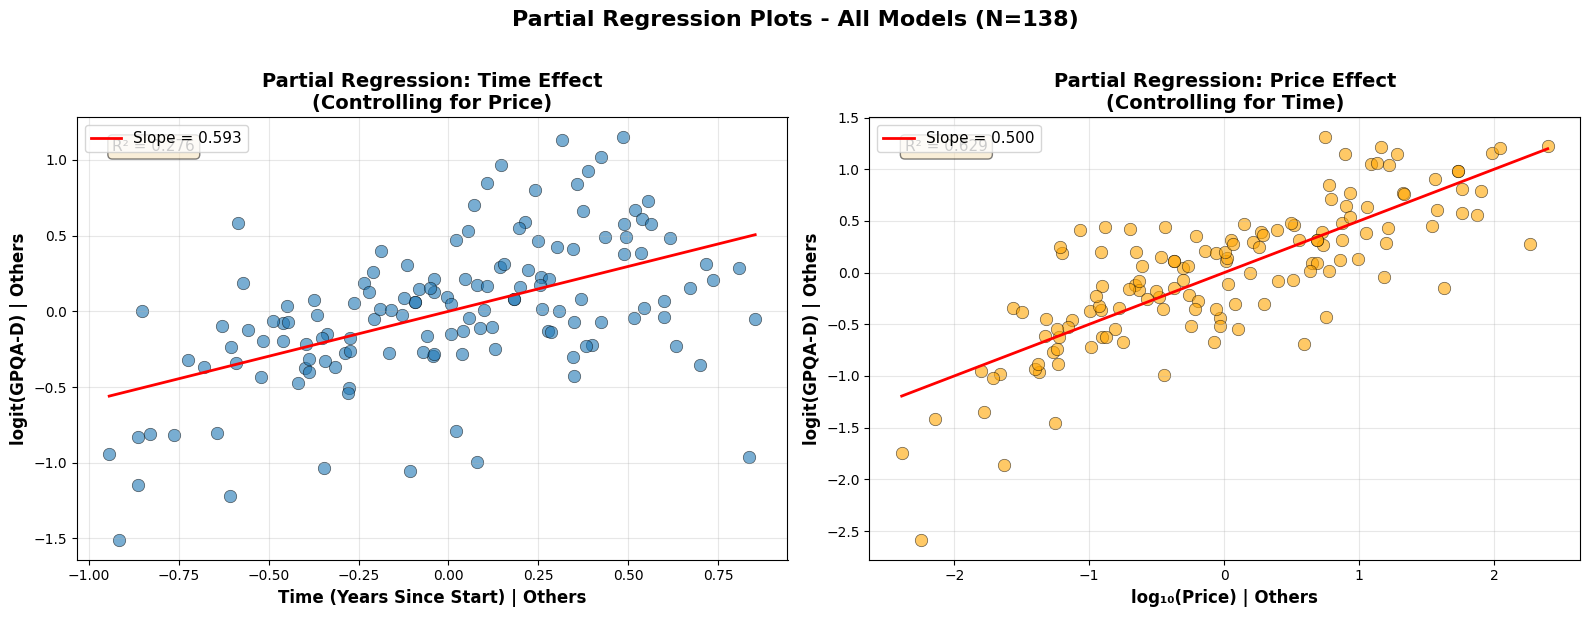

In [166]:
# Generate partial regression plots for all models
fig_all, axes_all = plot_partial_regression(
    results_all['data'], 
    results_all['model2'], 
    use_pareto_only=False)

### All Models Partial Regression Plots

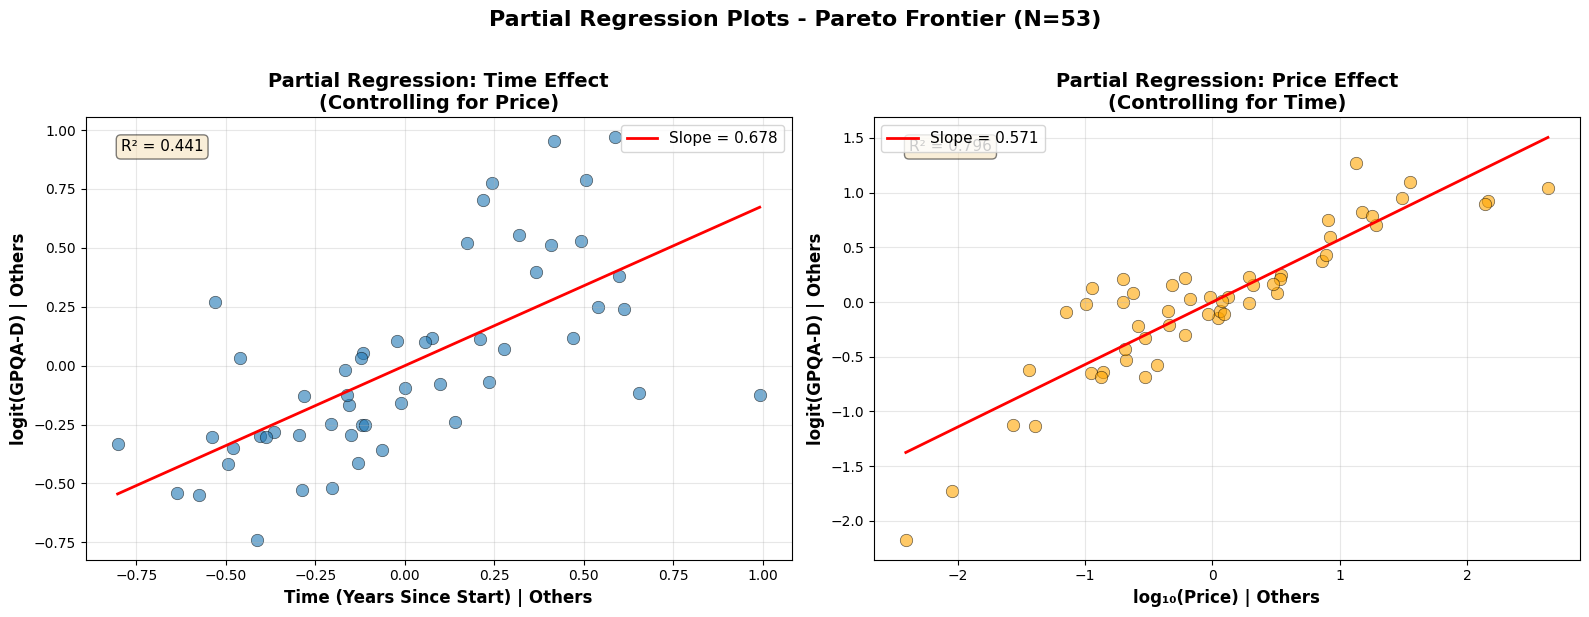

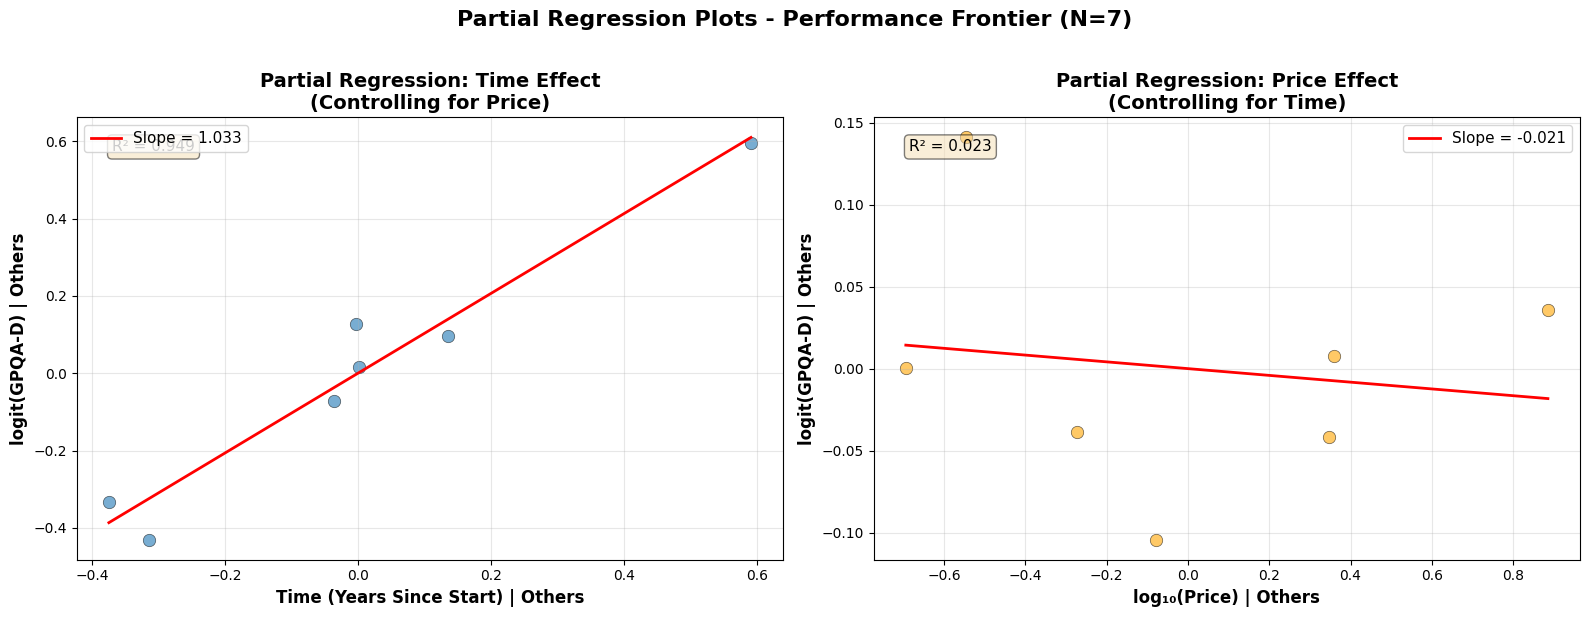

In [ ]:
# Generate partial regression plots for Pareto frontier
fig_pareto, axes_pareto = plot_partial_regression(
    results_pareto['data'],
    results_pareto['model2'],
    use_pareto_only=True,
    sample_label="Pareto Frontier"
)

# Generate partial regression plots for performance frontier
fig_frontier, axes_frontier = plot_partial_regression(
    results_frontier['data'],
    results_frontier['model2'],
    use_pareto_only=False,
    sample_label="Performance Frontier"
)

# Generate partial regression plots for AIME - Pareto frontier
fig_aime_pareto, axes_aime_pareto = plot_partial_regression(
    results_aime_pareto['data'],
    results_aime_pareto['model2'],
    use_pareto_only=True,
    sample_label="AIME Pareto Frontier",
    logit_col='AIME_logit',
    benchmark_name='AIME'
)

# Generate partial regression plots for AIME - Performance frontier
fig_aime_frontier, axes_aime_frontier = plot_partial_regression(
    results_aime_frontier['data'],
    results_aime_frontier['model2'],
    use_pareto_only=False,
    sample_label="AIME Performance Frontier",
    logit_col='AIME_logit',
    benchmark_name='AIME'
)

# Generate partial regression plots for AIME - All models
fig_aime_all, axes_aime_all = plot_partial_regression(
    results_aime_all['data'],
    results_aime_all['model2'],
    use_pareto_only=False,
    sample_label="AIME All Models",
    logit_col='AIME_logit',
    benchmark_name='AIME'
)

In [168]:
def run_quantile_regression_pareto(df, score_col, logit_col, benchmark_name, 
                                    quantiles=[0.1, 0.5, 0.9], min_date=None):
    """
    Run quantile regressions on Pareto frontier models.
    
    Args:
        df: DataFrame with model data
        score_col: Name of score column
        logit_col: Name of logit-transformed score column
        benchmark_name: Name for display
        quantiles: List of quantiles to estimate (e.g., [0.1, 0.5, 0.9])
        min_date: Optional minimum date filter
    
    Returns:
        Dictionary with results for each quantile
    """
    # Get Pareto frontier models
    df_work = df.copy()
    
    # Apply date filter if specified
    if min_date is not None:
        if isinstance(min_date, str):
            min_date = pd.to_datetime(min_date)
        df_work = df_work[df_work['Release Date'] >= min_date]
    
    # Sort by date
    df_work = df_work.sort_values('Release Date')
    
    # Identify Pareto frontier
    pareto_indices = []
    for date in df_work['Release Date'].unique():
        available_models = df_work[df_work['Release Date'] <= date].copy()
        available_models = available_models.sort_values(['Price', score_col])
        frontier_indices = []
        
        for i, row in available_models.iterrows():
            dominated = False
            for j in frontier_indices:
                frontier_row = available_models.loc[j]
                if (frontier_row[score_col] >= row[score_col] and 
                    frontier_row['Price'] <= row['Price'] and
                    (frontier_row[score_col] > row[score_col] or 
                     frontier_row['Price'] < row['Price'])):
                    dominated = True
                    break
            
            if not dominated:
                frontier_indices.append(i)
                new_frontier_indices = []
                for j in frontier_indices[:-1]:
                    frontier_row = available_models.loc[j]
                    if not (row[score_col] >= frontier_row[score_col] and 
                           row['Price'] <= frontier_row['Price'] and
                           (row[score_col] > frontier_row[score_col] or 
                            row['Price'] < frontier_row['Price'])):
                        new_frontier_indices.append(j)
                frontier_indices = new_frontier_indices + [i]
        
        current_date_models = df_work[df_work['Release Date'] == date]
        for i, row in current_date_models.iterrows():
            if i in frontier_indices:
                pareto_indices.append(i)
    
    pareto_indices = list(set(pareto_indices))
    df_pareto = df_work.loc[pareto_indices].copy()
    
    print(f"\n{'='*100}")
    print(f"{benchmark_name} - QUANTILE REGRESSION (Pareto Frontier, N={len(df_pareto)})")
    print(f"Date range: {df_pareto['Release Date'].min().strftime('%Y-%m-%d')} to {df_pareto['Release Date'].max().strftime('%Y-%m-%d')}")
    print(f"{score_col} range: {df_pareto[score_col].min():.1f}% to {df_pareto[score_col].max():.1f}%")
    print(f"{'='*100}\n")
    
    results = {}
    
    for q in quantiles:
        print(f"\n--- Quantile {q:.2f} (Q{int(q*100)}) ---")
        
        # Model 1: Without price control (logit_score ~ time)
        y = df_pareto[logit_col].values
        X_time = df_pareto[['Years_Since_Start']].values
        X_time_sm = sm.add_constant(X_time)
        
        qr1 = QuantReg(y, X_time_sm).fit(q=q)
        time_coef_1 = qr1.params[1]
        time_se_1 = qr1.bse[1]
        time_pval_1 = qr1.pvalues[1]
        
        # Calculate annual improvement in percentage points
        mean_score = df_pareto[score_col].mean()
        mean_logit_val = logit(mean_score / 100)
        future_logit_1 = mean_logit_val + time_coef_1
        future_prob_1 = inverse_logit(future_logit_1) * 100
        annual_pct_1 = future_prob_1 - mean_score
        
        pseudo_r2_1 = qr1.prsquared
        
        print(f"\nWithout Price Control:")
        print(f"  Time coef: {time_coef_1:.4f} (SE={time_se_1:.4f}, p={time_pval_1:.4e})")
        print(f"  Annual Δ: {annual_pct_1:.2f}% pts")
        print(f"  Pseudo R²: {pseudo_r2_1:.4f}")
        
        # Model 2: With price control (logit_score ~ time + log_price)
        X_time_price = df_pareto[['Years_Since_Start', 'log_Price']].values
        X_time_price_sm = sm.add_constant(X_time_price)
        
        qr2 = QuantReg(y, X_time_price_sm).fit(q=q)
        time_coef_2 = qr2.params[1]
        time_se_2 = qr2.bse[1]
        time_pval_2 = qr2.pvalues[1]
        price_coef_2 = qr2.params[2]
        price_se_2 = qr2.bse[2]
        price_pval_2 = qr2.pvalues[2]
        
        # Annual improvement for Model 2
        future_logit_2 = mean_logit_val + time_coef_2
        future_prob_2 = inverse_logit(future_logit_2) * 100
        annual_pct_2 = future_prob_2 - mean_score
        
        pseudo_r2_2 = qr2.prsquared
        
        print(f"\nWith Price Control:")
        print(f"  Time coef: {time_coef_2:.4f} (SE={time_se_2:.4f}, p={time_pval_2:.4e})")
        print(f"  Price coef: {price_coef_2:.4f} (SE={price_se_2:.4f}, p={price_pval_2:.4e})")
        print(f"  Annual Δ: {annual_pct_2:.2f}% pts")
        print(f"  Pseudo R²: {pseudo_r2_2:.4f}")
        
        results[q] = {
            'Benchmark': benchmark_name,
            'Quantile': q,
            'Quantile_Label': f'Q{int(q*100)}',
            'N': len(df_pareto),
            # Without price control
            'Time_Coef_NoPriceCtrl': time_coef_1,
            'Time_SE_NoPriceCtrl': time_se_1,
            'Time_p_NoPriceCtrl': time_pval_1,
            'Annual_PctPts_NoPriceCtrl': annual_pct_1,
            'Pseudo_R2_NoPriceCtrl': pseudo_r2_1,
            # With price control
            'Time_Coef_WithPriceCtrl': time_coef_2,
            'Time_SE_WithPriceCtrl': time_se_2,
            'Time_p_WithPriceCtrl': time_pval_2,
            'Price_Coef': price_coef_2,
            'Price_SE': price_se_2,
            'Price_p': price_pval_2,
            'Annual_PctPts_WithPriceCtrl': annual_pct_2,
            'Pseudo_R2_WithPriceCtrl': pseudo_r2_2,
        }
    
    return results

## Run Quantile Regression for All Benchmarks

Run quantile regression on Pareto frontier models with focus on 95th percentile (top performers).

In [169]:
# Run quantile regression for all three benchmarks
print("\n" + "="*100)
print("QUANTILE REGRESSION ANALYSIS - PARETO FRONTIER")
print("Focus on Q50 (median), Q75 (upper quartile), and Q95 (top 5%)")
print("="*100)

# GPQA-D
gpqa_quantile_results = run_quantile_regression_pareto(
    df_clean,
    score_col='GPQA_D',
    logit_col='GPQA_D_logit',
    benchmark_name='GPQA-D',
    quantiles=[0.50, 0.75, 0.95],
    min_date=datetime(2024, 4, 1)
)

# SWE-Bench
swe_quantile_results = run_quantile_regression_pareto(
    df_swe_clean,
    score_col='SWE_Bench',
    logit_col='SWE_Bench_logit',
    benchmark_name='SWE-Bench',
    quantiles=[0.50, 0.75, 0.95],
    min_date=datetime(2024, 4, 1)
)

# AIME
aime_quantile_results = run_quantile_regression_pareto(
    df_aime_clean,
    score_col='AIME',
    logit_col='AIME_logit',
    benchmark_name='AIME',
    quantiles=[0.50, 0.75, 0.95],
    min_date=datetime(2024, 4, 1)
)


QUANTILE REGRESSION ANALYSIS - PARETO FRONTIER
Focus on Q50 (median), Q75 (upper quartile), and Q95 (top 5%)

GPQA-D - QUANTILE REGRESSION (Pareto Frontier, N=53)
Date range: 2024-04-01 to 2025-09-01
GPQA_D range: 25.2% to 86.2%


--- Quantile 0.50 (Q50) ---

Without Price Control:
  Time coef: 1.4206 (SE=0.2340, p=1.5952e-07)
  Annual Δ: 29.27% pts
  Pseudo R²: 0.3611

With Price Control:
  Time coef: 0.6527 (SE=0.1254, p=3.6500e-06)
  Price coef: 0.5838 (SE=0.0475, p=9.6424e-17)
  Annual Δ: 15.39% pts
  Pseudo R²: 0.6992

--- Quantile 0.75 (Q75) ---

Without Price Control:
  Time coef: 1.7235 (SE=0.3038, p=6.6198e-07)
  Annual Δ: 33.23% pts
  Pseudo R²: 0.3322

With Price Control:
  Time coef: 1.1496 (SE=0.1478, p=3.6549e-10)
  Price coef: 0.4079 (SE=0.0473, p=1.8706e-11)
  Annual Δ: 25.01% pts
  Pseudo R²: 0.6709

--- Quantile 0.95 (Q95) ---

Without Price Control:
  Time coef: 0.9545 (SE=nan, p=nan)
  Annual Δ: 21.50% pts
  Pseudo R²: 0.3135

With Price Control:
  Time coef: 0.819

In [170]:
# Create comprehensive summary tables for quantile regression
print("\n" + "="*120)
print("QUANTILE REGRESSION SUMMARY: WITHOUT PRICE CONTROL")
print("="*120)

# Combine all quantile results
all_quantile_results = []
for results_dict in [gpqa_quantile_results, swe_quantile_results, aime_quantile_results]:
    for q, data in results_dict.items():
        all_quantile_results.append(data)

df_quantile = pd.DataFrame(all_quantile_results)

# Create table without price control
quantile_summary_no_ctrl = df_quantile[['Benchmark', 'Quantile_Label', 'Quantile', 'N',
                                          'Time_Coef_NoPriceCtrl', 'Time_SE_NoPriceCtrl', 'Time_p_NoPriceCtrl',
                                          'Annual_PctPts_NoPriceCtrl', 'Pseudo_R2_NoPriceCtrl']].copy()

quantile_summary_no_ctrl.columns = ['Benchmark', 'Quantile', 'Q', 'N',
                                     'Time Coef', 'Time SE', 'Time p-value',
                                     'Annual Δ (% pts)', 'Pseudo R²']

print(quantile_summary_no_ctrl.to_string(index=False))
quantile_summary_no_ctrl.to_csv('results/quantile_regression_no_price_control.csv', index=False)
print("\n\nSaved to: results/quantile_regression_no_price_control.csv")

print("\n" + "="*120)
print("QUANTILE REGRESSION SUMMARY: WITH PRICE CONTROL")
print("="*120)

# Create table with price control
quantile_summary_with_ctrl = df_quantile[['Benchmark', 'Quantile_Label', 'Quantile', 'N',
                                           'Time_Coef_WithPriceCtrl', 'Time_SE_WithPriceCtrl', 'Time_p_WithPriceCtrl',
                                           'Price_Coef', 'Price_SE', 'Price_p',
                                           'Annual_PctPts_WithPriceCtrl', 'Pseudo_R2_WithPriceCtrl']].copy()

quantile_summary_with_ctrl.columns = ['Benchmark', 'Quantile', 'Q', 'N',
                                       'Time Coef', 'Time SE', 'Time p-value',
                                       'Price Coef', 'Price SE', 'Price p-value',
                                       'Annual Δ (% pts)', 'Pseudo R²']

print(quantile_summary_with_ctrl.to_string(index=False))
quantile_summary_with_ctrl.to_csv('results/quantile_regression_with_price_control.csv', index=False)
print("\n\nSaved to: results/quantile_regression_with_price_control.csv")


QUANTILE REGRESSION SUMMARY: WITHOUT PRICE CONTROL
Benchmark Quantile    Q  N  Time Coef  Time SE  Time p-value  Annual Δ (% pts)  Pseudo R²
   GPQA-D      Q50 0.50 53     1.4206   0.2340    1.5952e-07           29.2729     0.3611
   GPQA-D      Q75 0.75 53     1.7235   0.3038    6.6198e-07           33.2311     0.3322
   GPQA-D      Q95 0.95 53     0.9545      NaN           NaN           21.4992     0.3135
SWE-Bench      Q50 0.50 13     0.9044   1.2598    4.8779e-01           21.2857     0.2210
SWE-Bench      Q75 0.75 13     0.9915      NaN           NaN           23.0551     0.1248
SWE-Bench      Q95 0.95 13     0.2679      NaN           NaN            6.6666     0.1697
     AIME      Q50 0.50 42     2.6436   0.8237    2.6216e-03           57.4538     0.2080
     AIME      Q75 0.75 42     3.8865   0.7740    1.1065e-05           69.3131     0.3012
     AIME      Q95 0.95 42     2.6263      NaN           NaN           57.2011     0.2199


Saved to: results/quantile_regression_no_price

In [171]:
# Highlight Q95 (95th percentile) results
print("\n" + "="*120)
print("FOCUS: 95TH PERCENTILE (TOP 5% OF MODELS) - KEY INSIGHTS")
print("="*120)

q95_results = df_quantile[df_quantile['Quantile'] == 0.95].copy()

for _, row in q95_results.iterrows():
    print(f"\n{row['Benchmark']} - {row['Quantile_Label']} (N={int(row['N'])})")
    print(f"{'='*80}")
    
    print(f"\nWithout Price Control:")
    print(f"  Time coefficient: {row['Time_Coef_NoPriceCtrl']:.4f} (SE={row['Time_SE_NoPriceCtrl']:.4f})")
    print(f"  Annual improvement: {row['Annual_PctPts_NoPriceCtrl']:.2f}% pts/year")
    print(f"  p-value: {row['Time_p_NoPriceCtrl']:.4e}")
    print(f"  Pseudo R²: {row['Pseudo_R2_NoPriceCtrl']:.4f}")
    
    print(f"\nWith Price Control:")
    print(f"  Time coefficient: {row['Time_Coef_WithPriceCtrl']:.4f} (SE={row['Time_SE_WithPriceCtrl']:.4f})")
    print(f"  Annual improvement: {row['Annual_PctPts_WithPriceCtrl']:.2f}% pts/year")
    print(f"  Price coefficient: {row['Price_Coef']:.4f} (SE={row['Price_SE']:.4f})")
    print(f"  Time p-value: {row['Time_p_WithPriceCtrl']:.4e}")
    print(f"  Price p-value: {row['Price_p']:.4e}")
    print(f"  Pseudo R²: {row['Pseudo_R2_WithPriceCtrl']:.4f}")
    
    # Calculate impact of price control
    delta_annual = row['Annual_PctPts_WithPriceCtrl'] - row['Annual_PctPts_NoPriceCtrl']
    pct_explained_by_price = (row['Annual_PctPts_NoPriceCtrl'] - row['Annual_PctPts_WithPriceCtrl']) / row['Annual_PctPts_NoPriceCtrl'] * 100
    
    print(f"\nImpact of Price Control:")
    print(f"  Reduction in annual improvement: {-delta_annual:.2f}% pts")
    print(f"  Progress explained by price increases: {pct_explained_by_price:.1f}%")
    print(f"  Algorithmic progress (price-independent): {100-pct_explained_by_price:.1f}%")

print("\n" + "="*120)
print("INTERPRETATION:")
print("="*120)
print("\n- 'Without Price Control' shows the RAW trend for top 5% of Pareto frontier models")
print("- 'With Price Control' isolates ALGORITHMIC progress independent of cost increases")
print("- The difference reveals how much progress comes from using more expensive models")
print("- Q95 trends show whether the best models are improving uniformly or diverging")


FOCUS: 95TH PERCENTILE (TOP 5% OF MODELS) - KEY INSIGHTS

GPQA-D - Q95 (N=53)

Without Price Control:
  Time coefficient: 0.9545 (SE=nan)
  Annual improvement: 21.50% pts/year
  p-value: nan
  Pseudo R²: 0.3135

With Price Control:
  Time coefficient: 0.8193 (SE=nan)
  Annual improvement: 18.86% pts/year
  Price coefficient: 0.3638 (SE=nan)
  Time p-value: nan
  Price p-value: nan
  Pseudo R²: 0.6055

Impact of Price Control:
  Reduction in annual improvement: 2.64% pts
  Progress explained by price increases: 12.3%
  Algorithmic progress (price-independent): 87.7%

SWE-Bench - Q95 (N=13)

Without Price Control:
  Time coefficient: 0.2679 (SE=nan)
  Annual improvement: 6.67% pts/year
  p-value: nan
  Pseudo R²: 0.1697

With Price Control:
  Time coefficient: 1.0417 (SE=nan)
  Annual improvement: 24.05% pts/year
  Price coefficient: 0.4142 (SE=nan)
  Time p-value: nan
  Price p-value: nan
  Pseudo R²: 0.4091

Impact of Price Control:
  Reduction in annual improvement: -17.38% pts
  Pro

## Partial Regression Plots

Partial regression plots (also called added-variable plots) show the relationship between each independent variable and the dependent variable after controlling for other variables. These plots help visualize the unique contribution of each predictor.